# M5 Forecast: Tidy R & CatBoost

The aim of this notebook is to provide a solution to the [M5 Forecast competition](https://www.kaggle.com/c/m5-forecasting-accuracy) by two core pieces:

1. R's sexy way to prepare data based on the Tidyverse. It is fast - the full data preparation takes only five minutes.

2. Yandex's gradient boosting implementation [CatBoost](https://catboost.ai). On my GPU (GeForce GTX 1080), fitting the model takes about five(!) minutes only. However, CUDA compatibility problems prevents using it here on the Kaggle cloud. Or is it just me? Let me know your thoughts on this.

The code logic basically follows my step-by-step [Python kernel](https://www.kaggle.com/mayer79/m5-forecast-poisson-loss), which itself was inspired by many other kernels.

**Don't forget to activate internet as we want to use a current version of CatBoost.**

## Packages, constants, data, functions

In [1]:
# Packages
suppressMessages({
  library(tidyverse)
  library(data.table)
  library(RcppRoll)
  if (packageVersion("catboost") < "0.22") { # At the time of writing, only version 0.12 is on Kaggle which e.g. does not support early_stopping_rounds
    devtools::install_url('https://github.com/catboost/catboost/releases/download/v0.22/catboost-R-Linux-0.22.tgz', INSTALL_opts = c("--no-multiarch"))  
  }
  library(catboost)
})

# Constants
FIRST <- 1914 # Start to predict from this "d"
LENGTH <- 28  # Predict so many days

# Data
main <- "../input/m5-forecasting-accuracy"
calendar <- fread(file.path(main, "calendar.csv"), stringsAsFactors = TRUE, 
                  drop = c("date", "weekday", "event_type_1", "event_type_2"))
train <- fread(file.path(main, "sales_train_validation.csv"), stringsAsFactors = TRUE,
               drop = paste0("d_", 1:1000))
prices <- fread(file.path(main, "sell_prices.csv"), stringsAsFactors = TRUE)

# Functions
d2int <- function(X) {
  X %>% extract(d, into = "d", "([0-9]+)", convert = TRUE)
}

demand_features <- function(X) {
  X %>% 
    group_by(id) %>% 
    mutate(lag_7 = dplyr::lag(demand, 7),
           lag_28 = dplyr::lag(demand, 28),
           roll_lag7_w7 = roll_meanr(lag_7, 7),
           roll_lag7_w28 = roll_meanr(lag_7, 28),
           roll_lag28_w7 = roll_meanr(lag_28, 7),
           roll_lag28_w28 = roll_meanr(lag_28, 28)) %>% 
    ungroup() 
}


✔  checking for file ‘/tmp/RtmpWzkyLp/remotesb50194fd8/catboost/DESCRIPTION’
─  preparing ‘catboost’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘catboost_0.22.tar.gz’
   


## Prepare data

In [2]:
train[, paste0("d_", FIRST:(FIRST + 2 * LENGTH - 1))] <- NA
train <- train %>% 
  mutate(id = gsub("_validation", "", id)) %>% 
  gather("d", "demand", -id, -item_id, -dept_id, -cat_id, -store_id, -state_id) %>% 
  d2int() %>% 
  left_join(calendar %>% d2int(), by = "d") %>% 
  left_join(prices, by = c("store_id", "item_id", "wm_yr_wk")) %>% 
  select(-wm_yr_wk) %>% 
  mutate(demand = as.numeric(demand)) %>% 
  mutate_if(is.factor, as.integer) %>% 
  demand_features() %>% 
  filter(d >= FIRST | !is.na(roll_lag28_w28))

# Response and features
y <- "demand"
x <- setdiff(colnames(train), c(y, "d", "id"))

Then we split the data into test, validation and training.

In [3]:
test <- train %>% 
    filter(d >= FIRST - 56)

train <- train %>% 
    filter(d < FIRST)

set.seed(3134)
idx <- sample(nrow(train), trunc(0.1 * nrow(train)))
valid <- catboost.load_pool(train[idx, x], label = train[[y]][idx])
train <- catboost.load_pool(train[-idx, x], label = train[[y]][-idx])
rm(prices, idx, calendar)
invisible(gc())

## It's time for CatBoost!

0:	learn: 3.2414606	test: 3.2676119	best: 3.2676119 (0)	total: 4.61s	remaining: 1h 55m 16s
10:	learn: 2.2650636	test: 2.2958532	best: 2.2958532 (10)	total: 37.5s	remaining: 1h 24m 32s
20:	learn: 2.2087655	test: 2.2450356	best: 2.2450356 (20)	total: 1m 9s	remaining: 1h 21m 54s
30:	learn: 2.1890061	test: 2.2268272	best: 2.2268272 (30)	total: 1m 42s	remaining: 1h 21m 16s
40:	learn: 2.1756424	test: 2.2159903	best: 2.2159903 (40)	total: 2m 15s	remaining: 1h 20m 6s
50:	learn: 2.1669164	test: 2.2092557	best: 2.2092557 (50)	total: 2m 48s	remaining: 1h 19m 42s
60:	learn: 2.1597824	test: 2.2022055	best: 2.2022055 (60)	total: 3m 21s	remaining: 1h 19m 7s
70:	learn: 2.1534293	test: 2.1981714	best: 2.1981714 (70)	total: 3m 54s	remaining: 1h 18m 38s
80:	learn: 2.1476773	test: 2.1932544	best: 2.1932544 (80)	total: 4m 27s	remaining: 1h 18m 9s
90:	learn: 2.1406905	test: 2.1893796	best: 2.1893796 (90)	total: 5m	remaining: 1h 17m 30s
100:	learn: 2.1354140	test: 2.1854284	best: 2.1854284 (100)	total: 5m 31

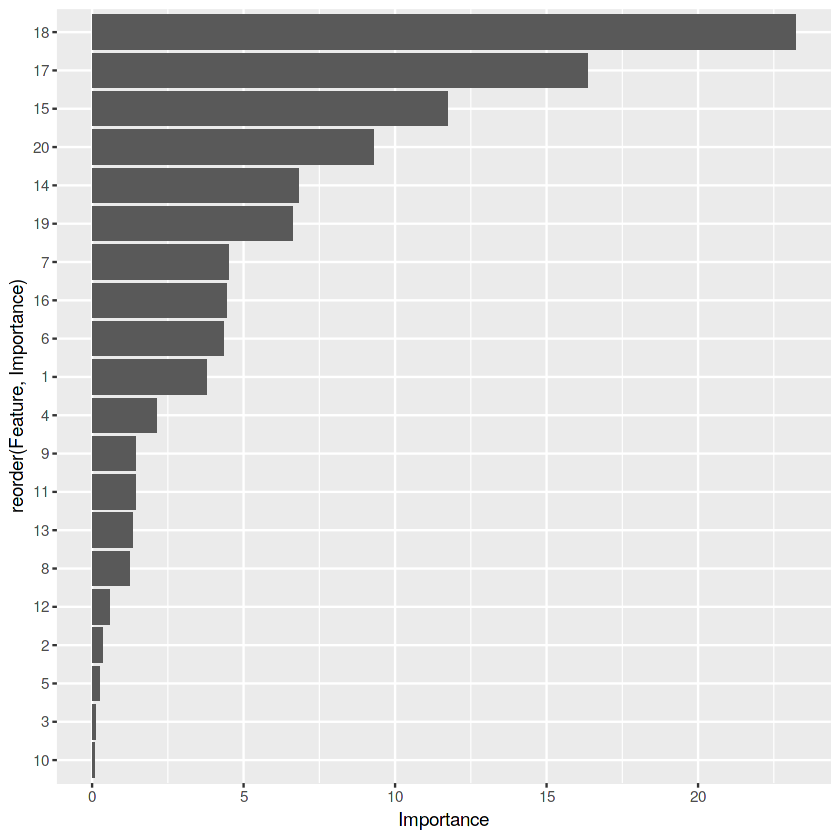

In [4]:
# Parameters
params <- list(iterations = 1500,
               metric_period = 10,
        #       task_type = "GPU",
               loss_function = "RMSE",
               eval_metric = "RMSE",
               random_strength = 0.5,
               depth = 7,
               # early_stopping_rounds = 400,
               learning_rate = 0.2,
               l2_leaf_reg = 0.1,
               random_seed = 93)

# Fit
fit <- catboost.train(train, valid, params = params)

# Variable importance plot
catboost.get_feature_importance(fit, valid) %>% 
  as.numeric() %>%
  enframe("Feature", "Importance") %>% 
  ggplot(aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity") +
  coord_flip()

## Submission

In [5]:
# Day by day predictions
for (day in FIRST:(FIRST + LENGTH - 1)) {
  cat(".")
  test[test$d == day, y] <- test %>% 
    filter(between(d, day - 56, day)) %>% 
    demand_features() %>% 
    filter(d == day) %>% 
    select_at(x) %>% 
    catboost.load_pool() %>% 
    catboost.predict(fit, .) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic
}

# Reshape to submission structure
submission <- test %>% 
  mutate(id = paste(id, ifelse(d < FIRST + LENGTH, "validation", "evaluation"), sep = "_"),
         F = paste0("F", d - FIRST + 1 - LENGTH * (d >= FIRST + LENGTH))) %>% 
  select(id, F, demand) %>% 
  spread(F, demand, fill = 1) %>% 
  select_at(c("id", paste0("F", 1:LENGTH)))

write_csv(submission, path = "submission.csv")

............................